In [ ]:
#Re-use Saptarshi and related tutorial's code to solve the image-based classification problem...

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

In [3]:
input_data = load_digits()
X = input_data.data
y = input_data.target

In [6]:
y[100], np.zeros(4)

(np.int64(4), array([0., 0., 0., 0.]))

In [4]:
#One-hot encoding
Y = []
for i in range(len(y)):
  y_dup = np.zeros(10)
  y_dup[y[i]] = 1
  Y.append(y_dup)
Y = np.array(Y)

In [5]:
def vizualize_number(data_point_index):
    plt.imshow(X[data_point_index].reshape(8,8), interpolation='nearest')
    plt.show()
    return ' '

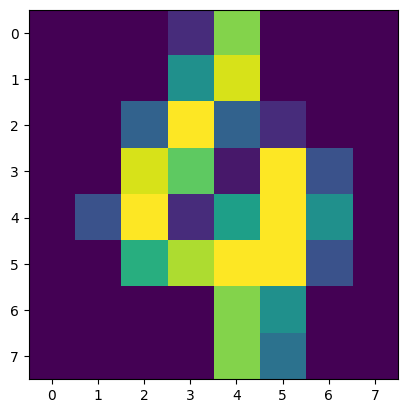

' '

In [9]:
vizualize_number(100)

In [10]:
len(X), X[100], Y[100]

(1797,
 array([ 0.,  0.,  0.,  2., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 15.,
         0.,  0.,  0.,  0.,  0.,  5., 16.,  5.,  2.,  0.,  0.,  0.,  0.,
        15., 12.,  1., 16.,  4.,  0.,  0.,  4., 16.,  2.,  9., 16.,  8.,
         0.,  0.,  0., 10., 14., 16., 16.,  4.,  0.,  0.,  0.,  0.,  0.,
        13.,  8.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  6.,  0.,  0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [ ]:
'''As we can observe that this data is already tokenised i.e. a number ranging from 0-16(?)
   of 64 dimensions so all we need is to embedding these numbers into vector so ultimately we
   need a matrix of 64 by some fixed dimension. Also since we're working on image which has
   fixed width and height for all images in datasets so there's no need for padding token.'''

In [6]:
from keras import layers as lay
import keras as ker
import tensorflow as tf
import random as ran

In [7]:
#Fixing initial random
ran.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [8]:
def pos_enc(inp_dim, d_model):
  mat = []
  for i in range(inp_dim):
    ls = []
    for j in range(d_model):
      if j%2==0:
        ls.append(np.sin((i+1)/(10000**(j/(d_model)))))
      else:
        ls.append(np.cos((i+1)/(10000**((j-1)/(d_model)))))
    mat.append(ls)
  return tf.cast(mat, dtype=tf.float32)

In [69]:
inp_layer = lay.Input(shape = (64, ))
enc_layer = lay.Embedding(input_dim = 17, output_dim = 32)(inp_layer)
Mult_Head_Att = lay.MultiHeadAttention(num_heads = 4, key_dim = 32, value_dim = 32)(enc_layer, enc_layer, enc_layer)
norm1 = lay.LayerNormalization(axis=1)(Mult_Head_Att)
dens1 = lay.Dense(48, activation='relu')(norm1)
norm2 = lay.LayerNormalization(axis=1)(dens1)
flat = lay.Flatten()(norm2)
dens2 = lay.Dense(48, activation='relu')(flat)
out_layer = lay.Dense(10, activation='sigmoid')(dens2)
model = ker.Model(inputs = inp_layer, outputs = out_layer)

In [70]:
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_47        │ (None, 64, 32)    │        544 │ input_layer_44[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 32)    │     16,800 │ embedding_47[0][… │
│ (MultiHeadAttentio… │                   │            │ embedding_47[0][… │
│                     │                   │            │ embedding_47[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 32)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64, 48)    │      1,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 48)    │        128 │ dense_16[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3072)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 48)        │    147,504 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10)        │        490 │ dense_17[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 167,178 (653.04 KB)

 Trainable params: 167,178 (653.04 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.compile(ker.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["binary_accuracy"])

In [19]:
from sklearn.model_selection import train_test_split as tts

In [20]:
x_train, x_test, y_train, y_test = tts(X, Y, test_size=0.3, random_state=42)

In [72]:
model.fit(x_train, y_train, epochs=15)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - binary_accuracy: 0.7127 - loss: 0.6659
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.8502 - loss: 0.4420
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9003 - loss: 0.3171
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9442 - loss: 0.1589
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.9738 - loss: 0.0829
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9809 - loss: 0.0627
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - binary_accuracy: 0.9844 - loss: 0.0522
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - binary_accuracy: 0.9871 - loss: 0.0451
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - binary_accuracy: 0.9896 - loss: 0.0399
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.9908 - loss: 0.0358
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - binary_accuracy: 0.9921 -

In [73]:
model.evaluate(x_test, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.9908 - loss: 0.0311


[0.03385531157255173, 0.9903703331947327]

In [74]:
test_no = len(x_test)
test_no

540

In [78]:
y_test[0], x_test[0].shape, x_train[0].shape

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), (64,), (64,))

In [79]:
count = 0
for i in range(test_no):
  y_pred = model.predict(x_test[i])
  sub_cou = 0
  for j in range(y_test[i]):
    if y_pred[j]==y_test[i][j]:
      sub_count = sub_count + 1
    else: continue
  if sub_count==10:
    count = count + 1
    sub_count = 0

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 64), but input has incompatible shape (32,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=False
  • mask=None

In [ ]:
#Let us try with including Positional encoding and other nitty gritty details of transformer

In [13]:
class TenseLayer(ker.Layer):
  def call(self, inputs):
    output = pos_enc(64, 32)
    return output

In [17]:
inp_layer = lay.Input(shape = (64, ))
enc_layer = lay.Embedding(input_dim = 17, output_dim = 32)(inp_layer)
#pos_layer = tf.add(enc_layer, pos_enc(64, 32))
#Mult_Head_Att = lay.MultiHeadAttention(num_heads = 4, key_dim = 32, value_dim = 32)(tf.add(enc_layer, pos_enc(64, 32)), tf.add(enc_layer, pos_enc(64, 32)), tf.add(enc_layer, pos_enc(64, 32)))
Mult_Head_Att = lay.MultiHeadAttention(num_heads = 4, key_dim = 32, value_dim = 32)(enc_layer+ pos_enc(64, 32), enc_layer+ pos_enc(64, 32), enc_layer+ pos_enc(64, 32))
norm1 = lay.LayerNormalization(axis=1)(Mult_Head_Att+enc_layer+pos_enc(64, 32))
dens1 = lay.Dense(32, activation='relu')(norm1)
norm2 = lay.LayerNormalization(axis=1)(dens1+norm1)
flat = lay.Flatten()(norm2)
dens2 = lay.Dense(48, activation='relu')(flat)
out_layer = lay.Dense(10, activation='sigmoid')(dens2)
NN = ker.Model(inputs = inp_layer, outputs = out_layer)

In [ ]:
''' Broken piece of script from which above cell was created

model = ker.Sequential()
model.add(lay.Input(shape = (64, ))) #The image is 8 x 8 pixel which leads to 64 dimension upon flattening it.
#print("Embedding", lay.Embedding(input_dim = 17, output_dim = 32), "\nPositional", pos_enc(64, 32))
enc_layer = model.add(lay.Embedding(input_dim = 17, output_dim = 32)) # + pos_enc(64, 32)) #Positional encoding is being dealt here, 32 is the embedded dimension
#enc_layer = enc_layer + pos_enc(64, 32)
enc_layer
#print("Encoded", enc_layer)
#Mult_Head_Atten = model.add(lay.MultiHeadAttention(num_heads = 4, key_dim = 32, value_dim = 32)) #(enc_layer)
#print("MultiHead", lay.MultiHeadAttention(key_dim = 32, num_heads = 4), "\nEmbed", lay.Embedding(input_dim = 17, output_dim = 32))

Norm1 = model.add(lay.Normalization(enc_layer)) #+Mult_Head_Atten))
model.add(lay.Dense(48, activation='relu'))
dens = model.add(lay.Dense(32))
Norm2 = model.add(lay.Normalization(dens+Norm1)) #Transformer encoder

model.add(lay.Dense(48, activation='relu'))
out_layer = model.add(10, activation='sigmoid')'''

In [18]:
NN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 64, 32)    │        544 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 32)    │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 64, 32)    │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 32)    │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 32)    │     16,800 │ add_10[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_11[0][0],     │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 64, 32)    │          0 │ multi_head_atten… │
│                     │                   │            │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 32)    │          0 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 32)    │        128 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 32)    │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 64, 32)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 32)    │        128 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 48)        │     98,352 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        490 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,498 (458.98 KB)

 Trainable params: 117,498 (458.98 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
NN.compile(ker.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["binary_accuracy"])

In [22]:
NN.fit(x_train, y_train, epochs=15)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - binary_accuracy: 0.7203 - loss: 0.5539
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - binary_accuracy: 0.9005 - loss: 0.3114
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9015 - loss: 0.2776
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.9050 - loss: 0.2437
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - binary_accuracy: 0.9151 - loss: 0.2100
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9306 - loss: 0.1806
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.9441 - loss: 0.1557
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - binary_accuracy: 0.9539 - loss: 0.1348
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - binary_accuracy: 0.9634 - loss: 0.1174
Epoch 10/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - binary_accuracy: 0.9685 - loss: 0.1025
Epoch 11/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - binary_accuracy: 0.9734 

In [24]:
NN.evaluate(x_test, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - binary_accuracy: 0.9803 - loss: 0.0649


[0.06810273975133896, 0.9790740013122559]

In [ ]:
'''The addition of rigid normalisation and positional encoding doesn't give any performance boost,
   thus in the imaging recognition problem or at least in case of 8 x 8 pixel this amount of spatial
   detailing proves to be unnecessary.'''